<a href="https://colab.research.google.com/github/jvictorferreira3301/Prob-Stat/blob/main/lab02.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 27px; margin-right: 10px;"/>


## O problema:

Os dados referenciados abaixo mostram o diâmetro de Pizzas medidas na Austrália. A pizzaria EagleBoys afirma que suas pizzas são maiores do que as da pizzaria Dominos. Para provar isso, eles realizaram um conjunto de medições e as publicaram. Normalmente, não é esperado que cada pizza produzida por um restaurante tenha exatamente o mesmo tamanho, mas deve-se esperar algo próximo entre as pizzas produzidas. 

Veja que essa não é apenas uma história engraçada. O gerente de uma pizzaria precisa controlar custos e trazer clientela. Considerando duas pizzas de mesmo sabor, tipo de massa e preço, uma pizza maior significa menor lucro naquela pizza, enquanto que uma pizza menor do que o esperado implica em desagradar o cliente. Parece não haver uma estratégia única para determinar a medida certa para manter seu lucro, e isso dá origem à diferentes abordagens pelas pizzarias. Será que veremos estratégias diferentes nestes dados?



### O que fazer?

Agora você vai investigar os dados destas medições. Explore os dados usando o que você aprendeu e anote o que foi observado. Apresente um link de compartilhamento do seu colab, compartilhado para comentários. Ele deve conter código e texto explicativo.

### Questões motivadoras

As questões abaixo não são exaustivas, mas apenas um guia. Tente elaborar suas próprias questões ao analisar os dados.

Que tipos de variáveis temos no conjunto de dados?
Será que a alegação da pizzaria EagleBoys tem alguma base?
O tipo de massa (crust, em inglês) ou o sabor (topping, em inglês) impactam no tamanho da pizza?
Haveria alguma explicação para as diferenças?
Dados

https://github.com/glaucogoncalves/p-e/raw/main/Labs/lab-pizza/ujse_a_11889637_sm1111.zip

#### Mais sobre os dados e o problema

http://jse.amstat.org/v20n1/dunn.pdf


In [31]:
# importação das bibliotecas

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import os
import requests
import zipfile
from scipy.stats import ttest_ind, kruskal

Primeiramente, configuramos o download e descompactação dos dados de interesse:

In [32]:
# url do arquivo
url = "https://github.com/glaucogoncalves/p-e/raw/main/Labs/lab-pizza/ujse_a_11889637_sm1111.zip"
# nome
zip_path = "./data/ujse_a_11889637_sm1111.zip"
# pasta pra onde vai
extract_path = "./data"

# cria a pasta de destino se não existir
os.makedirs(extract_path, exist_ok=True)

# download do arquivo apenas se ele não existir
if not os.path.exists(zip_path):
    response = requests.get(url)
    with open(zip_path, 'wb') as file:
        file.write(response.content)

# descompacta o arquivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# remove o zip após a descompactação
os.remove(zip_path)

print("Download e descompactação concluídos.")

Download e descompactação concluídos.


## $I$. Inferências primárias



Fazemos algumas inferências primárias através da biblioteca pandas

In [33]:
data_pizza = pd.read_csv('data/pizzasize.csv')
data_pizza.describe()

,ID,Diameter
count,250.000000,250.000000
mean,125.972000,28.308200
std,72.941105,1.276376
min,1.000000,25.510000
25%,63.250000,26.885000
50%,125.500000,28.765000
75%,187.750000,29.237500
max,252.000000,31.060000


Na saída da célula acima podemos evidenciar a quantidade de pizzas medidas(`250`), a média do diâmetro (`28,3`) e os percentis dos mesmos. 

In [34]:
print(data_pizza.head(10))
print('\n')
print(data_pizza['Store'].unique())
print(data_pizza['CrustDescription'].unique())
print(data_pizza['Topping'].unique())

   ID      Store CrustDescription        Topping  Diameter
0   1    Dominos      ThinNCrispy        Supreme     29.40
1   2    Dominos      ThinNCrispy  BBQMeatlovers     29.63
2   3    Dominos          DeepPan       Hawaiian     27.06
3   4    Dominos      ThinNCrispy        Supreme     27.45
4   5    Dominos     ClassicCrust       Hawaiian     26.59
5   6    Dominos          DeepPan  BBQMeatlovers     27.16
6   7  EagleBoys         MidCrust   SuperSupremo     29.15
7   8  EagleBoys          DeepPan       Hawaiian     28.78
8   9  EagleBoys        ThinCrust  BBQMeatlovers     30.05
9  10  EagleBoys          DeepPan  BBQMeatlovers     29.38


['Dominos' 'EagleBoys']
['ThinNCrispy' 'DeepPan' 'ClassicCrust' 'MidCrust' 'ThinCrust']
['Supreme' 'BBQMeatlovers' 'Hawaiian' 'SuperSupremo']


Vemos acima as nossas variáveis representadas pelas colunas. 

Podemos ver 3 variaveis categóricas e seus valores distintos que podem ser assumidos, que também podemos entender como o suporte das nossas VAs:
- `Store` : As duas pizzarias em questão.
- `CrustDescription` : Os tipos de massa.
- `Topping`: Os sabores.

E uma variável numérica, tendo em seu suport entre 25.51 e 31.06:

- `Diameter`: $25.51<x<31.06$

In [35]:
print(data_pizza.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                250 non-null    int64  
 1   Store             250 non-null    object 
 2   CrustDescription  250 non-null    object 
 3   Topping           250 non-null    object 
 4   Diameter          250 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB
None


## $II$. Será que a alegação da pizzaria EagleBoys tem alguma base?


Para avaliar se a afirmação da pizzaria EagleBoys faz sentido vamos calcular na célula abaixo a média do diâmetro (variável `Diameter`) das pizzas medidas de cada pizzaria (variável `Store`)

In [36]:
# Compare the average diameter of pizzas from different stores
mean_diameter_by_store = data_pizza.groupby('Store')['Diameter'].mean()
print(mean_diameter_by_store)

Store
Dominos      27.44208
EagleBoys    29.17432
Name: Diameter, dtype: float64


Como podemos visualizar, de fato, em média a pizzaria EagleBoys tem pizzas com diâmetros maiores, fato que corrobora a alegação.

Para vermos essa superioridade de maneira mais visual podemos plotar um _boxplot_ com a distribuição dos diâmetros das pizzas por pizzaria:

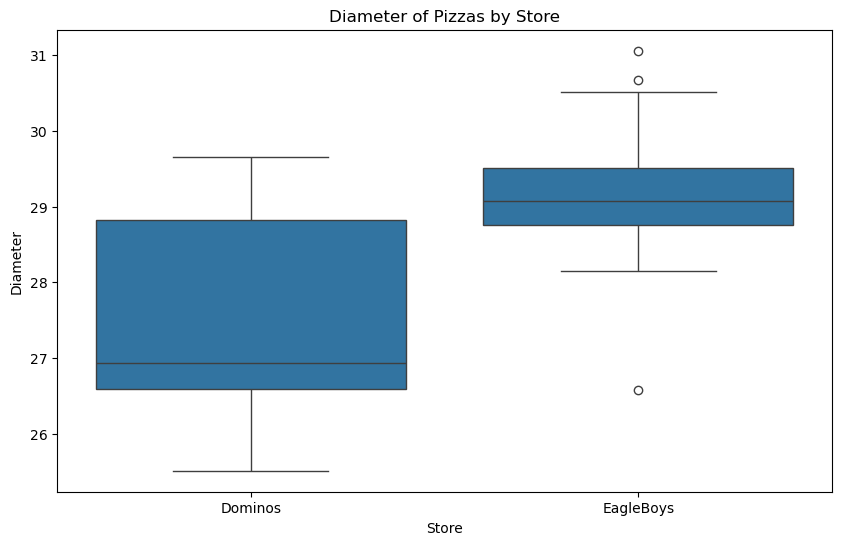

In [37]:
# boxplot do diametro pela pizzaria
plt.figure(figsize=(10, 6))
sns.boxplot(x='Store', y='Diameter', data=data_pizza)
plt.title('Diâmetros das pizzas pela pizzaria. Boxplot 1')
plt.show()

Podemos notar que os _outliers_ superiores corroboram também com a afirmação da pizzara EagleBoys.

Outra questão que podemos inferir com este _boxplot_ é que a pizzaria Dominos apresenta a maior variação no diâmetro das pizzas. A distância entre o quartil inferior e o quartil superior é maior em comparação com a pizzaria EagleBoys, e os 'bigodes' também são mais longos, indicando uma maior dispersão dos dados. Para provar isso, vejamos a célula abaixo:

In [52]:
# ffiltragem
eagleboys_diameter = data_pizza[data_pizza['Store'] == 'EagleBoys']['Diameter']
dominos_diameter = data_pizza[data_pizza['Store'] == 'Dominos']['Diameter']

# variância e o desvio padrão
eagleboys_variance = eagleboys_diameter.var()
dominos_variance = dominos_diameter.var()

eagleboys_std = eagleboys_diameter.std()
dominos_std = dominos_diameter.std()

# resultados
print(f"EagleBoys - Variância: {eagleboys_variance}, Desvio Padrão: {eagleboys_std}")
print(f"Dominos - Variância: {dominos_variance}, Desvio Padrão: {dominos_std}")

EagleBoys - Variância: 0.3922553806451615, Desvio Padrão: 0.6263029463807124
Dominos - Variância: 1.3667295096774188, Desvio Padrão: 1.16907207206289


Os cálculos mostram que a variância e o desvio padrão dos diâmetros das pizzas da Dominos são significativamente maiores do que os da EagleBoys. Isso confirma quantitativamente que a pizzaria Dominos apresenta maior variação no diâmetro das pizzas em comparação com a pizzaria EagleBoys, corroborando a observação feita a partir do boxplot.

## $III$. Existe uma diferença significativa no diâmetro médio das pizzas entre as pizzarias EagleBoys e Dominos?


Ja sabemos que, em média, a pizzaria EagleBoys tem pizzas com diâmetros maiores, mas, há uma diferença significativa no diâmetro médio das pizzas entre as duas pizzarias?


Para isso, formulamos a seguinte hipótese para serem testadas:

- Hipótese Nula (H0): Não há diferença significativa no diâmetro médio das pizzas entre a pizzaria EagleBoys e a pizzaria Dominos.

- Hipótese Alternativa (H1): O diâmetro médio das pizzas da pizzaria EagleBoys é significativamente maior do que o diâmetro médio das pizzas da pizzaria Dominos.
Utilizaremos um teste t de Student para comparar os diâmetros médios das pizzas das duas pizzarias e verificar se a alegação da EagleBoys tem fundamento.



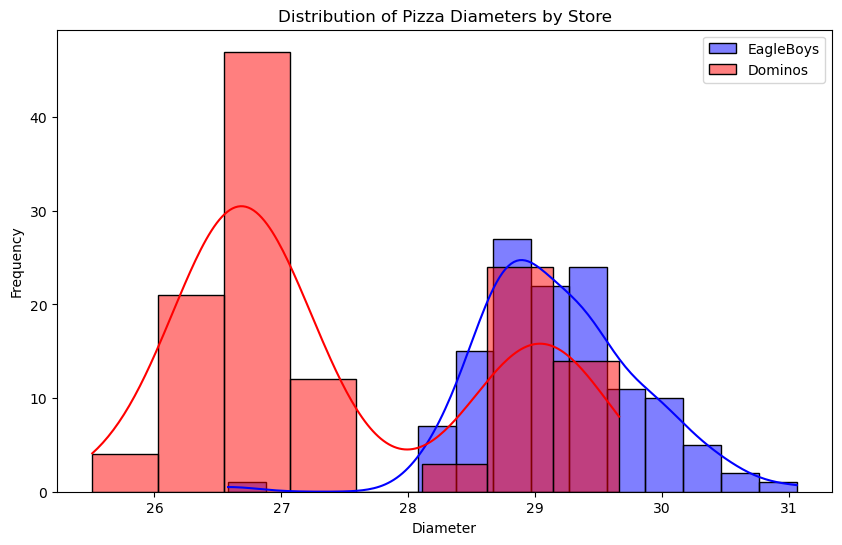

T-Statistic: 14.60266139490296
P-Value: 2.851940019877747e-35
Rejeitamos a hipótese nula. Há uma diferença significativa no diâmetro médio das pizzas entre EagleBoys e Dominos.


In [38]:
# Filtagrem
eagleboys_data = data_pizza[data_pizza['Store'] == 'EagleBoys']
dominos_data = data_pizza[data_pizza['Store'] == 'Dominos']

# Visualização de dists
plt.figure(figsize=(10, 6))
sns.histplot(eagleboys_data['Diameter'], kde=True, label='EagleBoys', color='blue')
sns.histplot(dominos_data['Diameter'], kde=True, label='Dominos', color='red')
plt.legend()
plt.title('Distribution of Pizza Diameters by Store')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.show()

# Teste de hipótese 
t_stat, p_value = ttest_ind(eagleboys_data['Diameter'], dominos_data['Diameter'])
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# resultados
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa no diâmetro médio das pizzas entre EagleBoys e Dominos.")
else:
    print("Não rejeitamos a hipótese nula. Não há diferença significativa no diâmetro médio das pizzas entre EagleBoys e Dominos.")

Com base nos resultados do teste t de Student, obtivemos um valor de T-Statistic de 14,60 e um P-Value de 2,85. Dado que o P-Value é significativamente menor que o nível de significância α = 0.05, rejeitamos a hipótese nula (H0).

Portanto, concluímos que há uma diferença significativa no diâmetro médio das pizzas entre as pizzarias EagleBoys e Dominos. Especificamente, as pizzas da EagleBoys têm um diâmetro médio significativamente maior do que as pizzas da Dominos, corroborando a alegação da pizzaria EagleBoys.

## $IV$. O tipo de massa ou o sabor impactam no tamanho da pizza?


Para testarmos essa questão, utilizamos o teste de `Kruskal-Wallis`, que é uma alternativa não paramétrica à `ANOVA` e é apropriado para dados que não seguem uma distribuição normal, que é o nosso caso.

Primeiro, aplicamos na célula abaixo o teste de `Kruskal-Wallis` para comparar os diâmetros das pizzas entre diferentes tipos de massa e sabores. Este teste verifica se há diferenças significativas nas medianas dos grupos comparados.

In [39]:
# teste de Kruskal-Wallis
crust_groups = [data_pizza[data_pizza['CrustDescription'] == crust]['Diameter'] for crust in data_pizza['CrustDescription'].unique()]
stat, p_value_crust = kruskal(*crust_groups)
print(f"Teste de Kruskal-Wallis para tipo de massa: Estatística={stat}, Valor-p={p_value_crust}")

topping_groups = [data_pizza[data_pizza['Topping'] == topping]['Diameter'] for topping in data_pizza['Topping'].unique()]
stat, p_value_topping = kruskal(*topping_groups)
print(f"Teste de Kruskal-Wallis para sabor: Estatística={stat}, Valor-p={p_value_topping}")

alpha = 0.05
if p_value_crust < alpha:
    print("Rejeitamos a hipótese nula. O tipo de massa impacta significativamente no tamanho da pizza.")
else:
    print("Não rejeitamos a hipótese nula. O tipo de massa não impacta significativamente no tamanho da pizza.")

if p_value_topping < alpha:
    print("Rejeitamos a hipótese nula. O sabor impacta significativamente no tamanho da pizza.")
else:
    print("Não rejeitamos a hipótese nula. O sabor não impacta significativamente no tamanho da pizza.")

Teste de Kruskal-Wallis para tipo de massa: Estatística=118.077467927284, Valor-p=1.3747861451326749e-24
Teste de Kruskal-Wallis para sabor: Estatística=23.768251208214945, Valor-p=2.792326337325962e-05
Rejeitamos a hipótese nula. O tipo de massa impacta significativamente no tamanho da pizza.
Rejeitamos a hipótese nula. O sabor impacta significativamente no tamanho da pizza.


Os resultados dos testes de Kruskal-Wallis indicam que tanto o tipo de massa quanto o sabor impactam significativamente no tamanho da pizza. Para corroborar com isto nas células seguintes são plotados gráficos de caixa que evidenciam a afirmação:

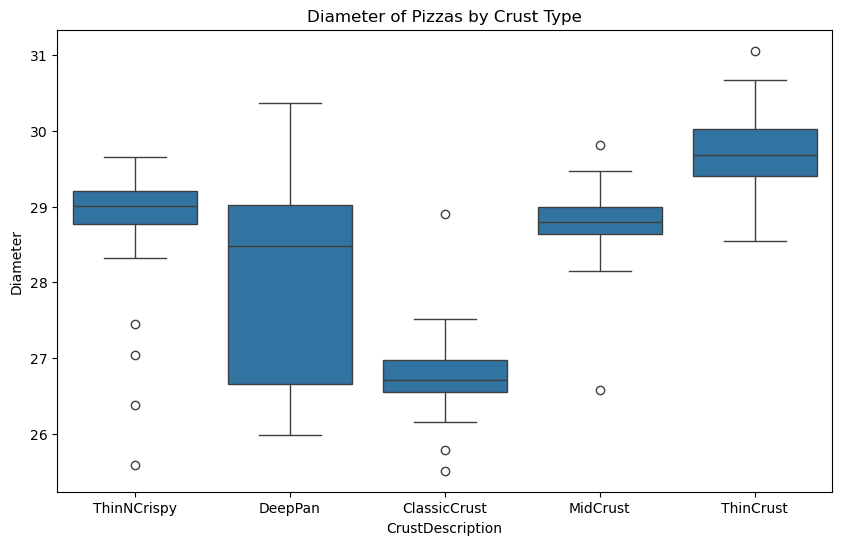

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='CrustDescription', y='Diameter', data=data_pizza)
plt.title('Diâmetros das pizzas pelo tipo de massa. Boxplot 2')
plt.show()

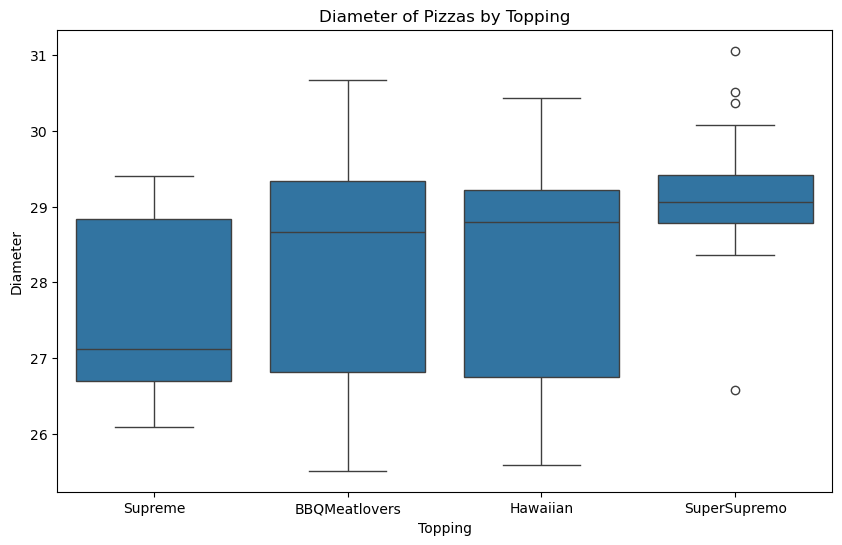

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topping', y='Diameter', data=data_pizza)
plt.title('Diâmetros das pizzas pelo sabor. Boxplot 3')
plt.show()

Nos gráfico gerado, cada caixa representa a distribuição dos diâmetros das pizzas para um tipo específico de massa (no _Boxplot_ 2) ou sabor (No _Boxplot_ 3). A linha dentro de cada caixa indica a mediana do diâmetro das pizzas para aquele tipo de massa (ou sabor). As extremidades da caixa representam o primeiro e o terceiro quartis, enquanto os "bigodes" se estendem até os valores mínimos e máximos, excluindo os outliers, que são representados por pontos individuais.

A análise visual dos _Boxplots_ revela que há variações significativas nos diâmetros das pizzas entre os diferentes tipos de massa (e sabores). Essas variações são evidenciadas pelas diferenças nas medianas e pela amplitude das distribuições dos diâmetros.

Essas observações corroboram os resultados do teste de Kruskal-Wallis, que indicou que o tipo de massa impacta significativamente o diâmetro das pizzas (Estatística=118.07, Valor-p=1.3747861451326749e-24). Portanto, podemos concluir que o tipo de massa e sabor são fatores determinantes no tamanho das pizzas oferecidas.


Nas células podemos ver a mesma inferência de outras maneiras como pelo gŕafico de densidade.

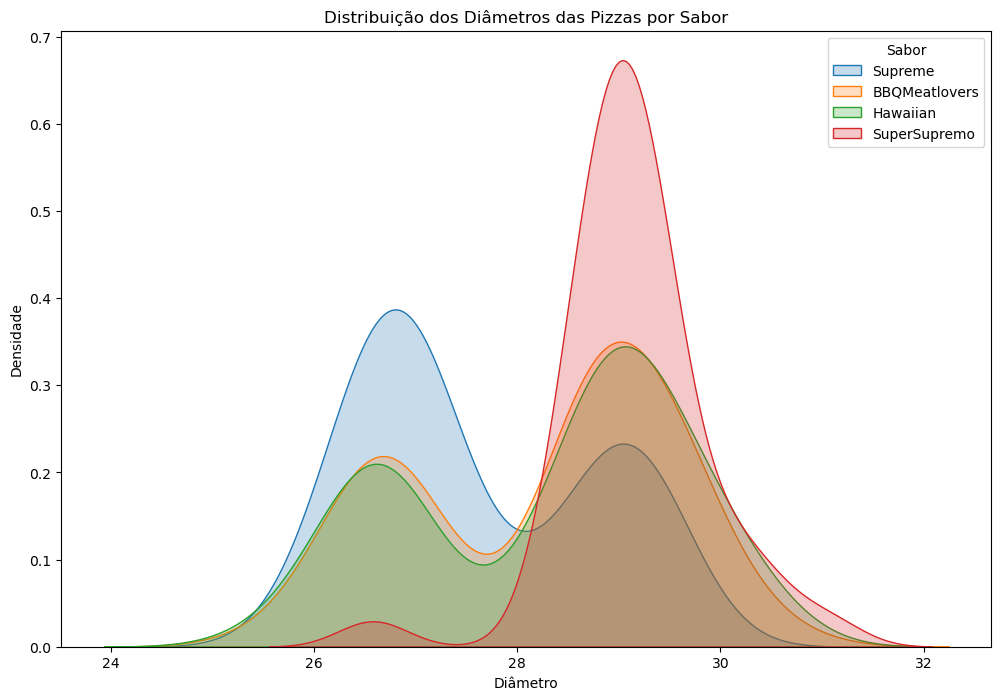

In [45]:
plt.figure(figsize=(12, 8))
for topping in data_pizza['Topping'].unique():
    subset = data_pizza[data_pizza['Topping'] == topping]
    sns.kdeplot(subset['Diameter'], label=topping, fill=True)
plt.title('Distribuição dos Diâmetros das Pizzas por Sabor')
plt.xlabel('Diâmetro')
plt.ylabel('Densidade')
plt.legend(title='Sabor')
plt.show()

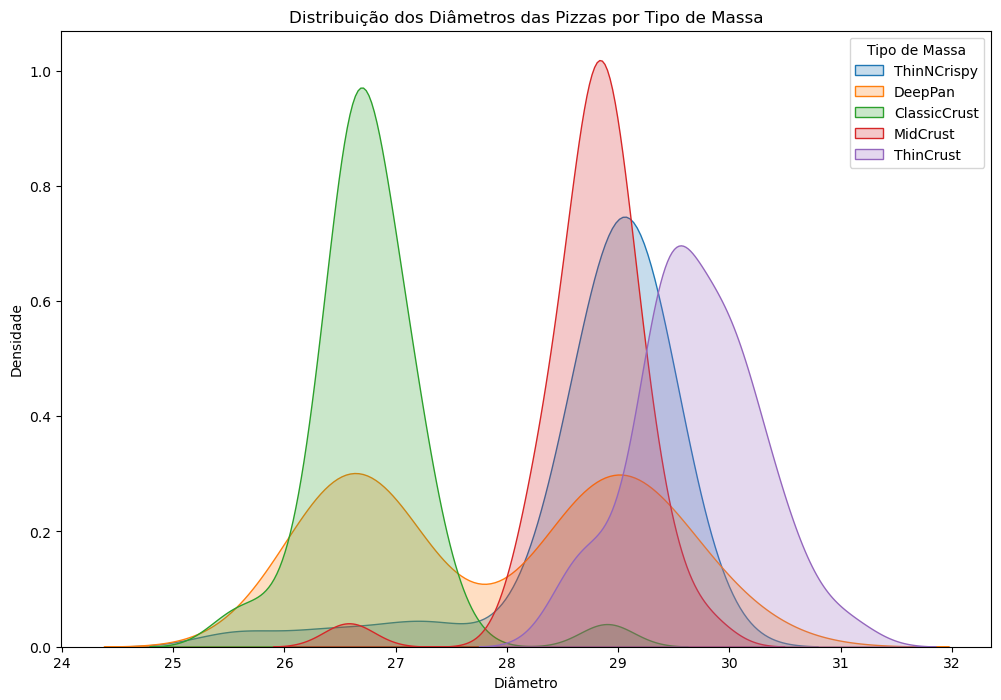

In [48]:
plt.figure(figsize=(12, 8))
for crust in data_pizza['CrustDescription'].unique():
    subset = data_pizza[data_pizza['CrustDescription'] == crust]
    sns.kdeplot(subset['Diameter'], label=crust, fill=True)
plt.title('Distribuição dos Diâmetros das Pizzas por Tipo de Massa')
plt.xlabel('Diâmetro')
plt.ylabel('Densidade')
plt.legend(title='Tipo de Massa')
plt.show()

Os gráficos de densidade resultantes mostram como os diâmetros das pizzas são distribuídos para cada tipo de massa e sabor. Cada curva representa a distribuição de diâmetros para um tipo específico de massa e sabor, permitindo comparar visualmente as distribuições entre os diferentes tipos de massa.

- **Picos das Curvas:** Indicam os diâmetros mais comuns para cada tipo de massa.
- **Largura das Curvas:** Indica a variabilidade dos diâmetros para cada tipo de massa. Curvas mais largas sugerem maior variabilidade, enquanto curvas mais estreitas indicam menor variabilidade.
- **Áreas Preenchidas:** Facilitam a visualização das distribuições e ajudam a identificar rapidamente as diferenças entre os tipos de massa.

Por último, os _boxplots_ seguintes permitem comparar a distribuição dos diâmetros das pizzas para diferentes combinações de tipo de massa e sabor.

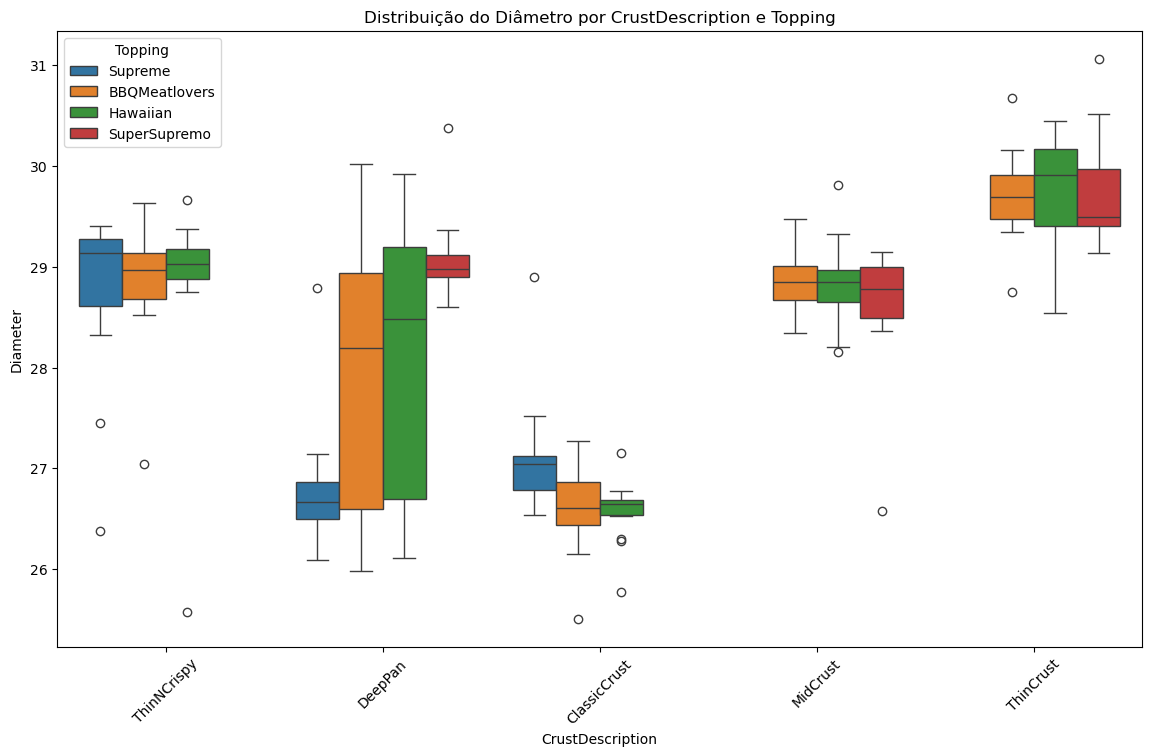

In [46]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_pizza, x='CrustDescription', y='Diameter', hue='Topping')
plt.title('Distribuição do Diâmetro por CrustDescription e Topping')
plt.xticks(rotation=45)
plt.show()

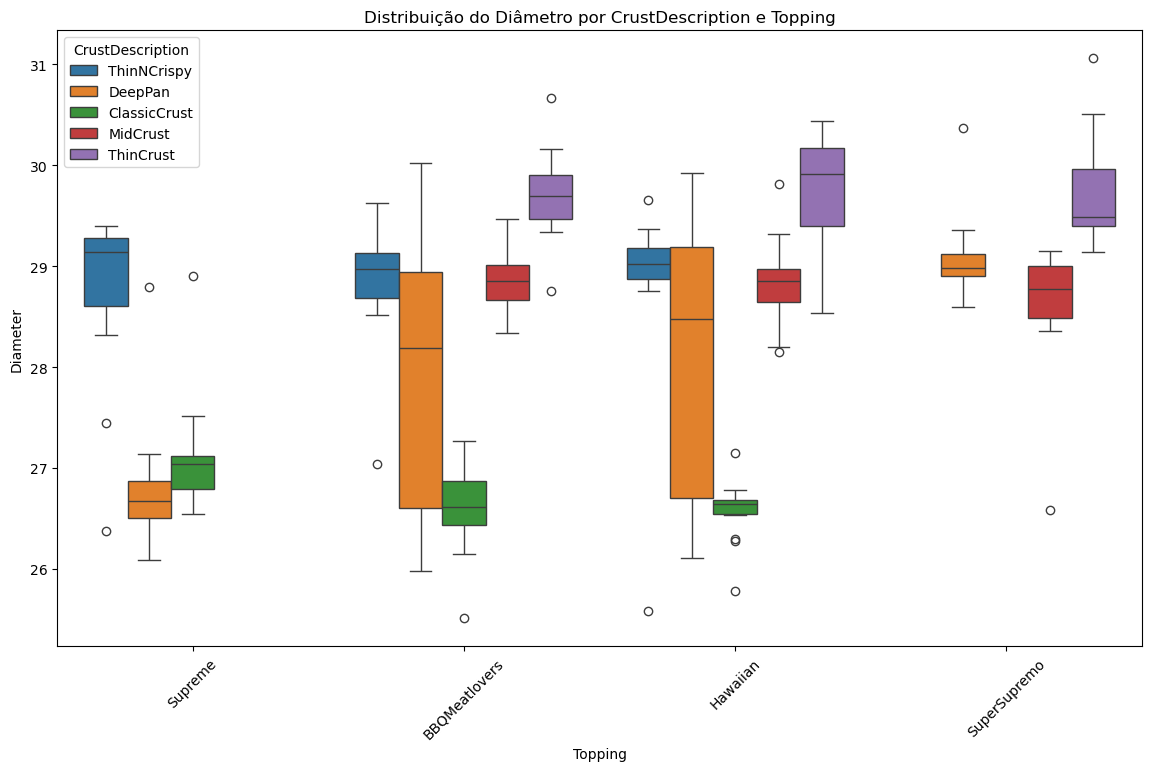

In [47]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_pizza, x='Topping', y='Diameter', hue='CrustDescription')
plt.title('Distribuição do Diâmetro por CrustDescription e Topping')
plt.xticks(rotation=45)
plt.show()